In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
import os
from pathlib import Path
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
from datetime import datetime
from custom_anomaly_detector import build_ov_anomaly_detector, OVAnomalyDetector
from llava.model.anomaly_expert import AnomalyOV
from utils_trends.image_processing import process_anyres_image

print("Imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"MPS available: {torch.backends.mps.is_available()}")

Imports successful!
PyTorch version: 2.9.1
CUDA available: False
MPS available: True


In [12]:
# Configuration
class Config:
    # Dataset paths - now with train/eval/test split
    data_root = "./finetune_dataset"
    
    # Model configuration
    vision_tower_name = "google/siglip-so400m-patch14-384"
    anomaly_expert_path = "./pretrained_expert_05b.pth"  # Change to pretrained_expert_7b.pth for 7B model
    
    # Training hyperparameters (aligned with original training)
    batch_size = 4  # Reduced from 128 due to single device (8x H100 -> 1x MPS)
    num_epochs = 2  # Match original training
    learning_rate = 1e-4  # Match original initial LR
    weight_decay = 1e-5
    tensorboard_log_dir = "./logs"
    # Device configuration
    device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
    dtype = torch.float32  # Use float32 for training stability
    
    # Checkpointing
    checkpoint_dir = "./checkpoints"
    save_every = 1  # Save checkpoint every N epochs
    
    # Image size (must match vision tower)
    image_size = 384
    
    # Load anyres configuration from config.json
    config_path = "./config.json"
    with open(config_path, 'r') as f:
        model_config = json.load(f)
    
    image_aspect_ratio = model_config.get("image_aspect_ratio", "anyres_max_9")
    image_grid_pinpoints = model_config.get("image_grid_pinpoints", [])
    
config = Config()
print(f"Using device: {config.device}")
print(f"Data root: {config.data_root}")
print(f"Image aspect ratio: {config.image_aspect_ratio}")
print(f"Grid pinpoints: {len(config.image_grid_pinpoints)} configurations")
print(f"Example grid pinpoints: {config.image_grid_pinpoints[:3]}")
os.makedirs(config.checkpoint_dir, exist_ok=True)

# Verify dataset structure
print("\nDataset structure:")
for split in ['train', 'eval', 'test']:
    split_path = Path(config.data_root) / split
    if split_path.exists():
        inpainted_count = len(list((split_path / "inpainted").glob("*.png"))) + len(list((split_path / "inpainted").glob("*.jpg")))
        print(f"  {split}/: {inpainted_count} images")
    else:
        print(f"  {split}/: NOT FOUND")


Using device: mps
Data root: ./finetune_dataset
Image aspect ratio: anyres_max_9
Grid pinpoints: 36 configurations
Example grid pinpoints: [[384, 384], [384, 768], [384, 1152]]

Dataset structure:
  train/: 4347 images
  eval/: 931 images
  test/: 933 images


In [3]:
# Custom Dataset for Anomaly Detection Fine-tuning with AnyRes
class AnomalyDataset(Dataset):
    """
    Dataset for anomaly detection with real images, inpainted images, and masks.
    Uses anyres preprocessing to handle variable resolutions and aspect ratios.
    
    Now supports pre-split dataset structure: train/eval/test folders.
    
    Returns:
        - patches: Multi-patch tensor [num_patches+1, 3, 384, 384]
        - label: Binary label (0=normal, 1=anomaly)
        - num_patches: Number of patches for this image
        - mask: Binary mask indicating anomaly regions
    """
    def __init__(self, data_root, image_processor, split="train", max_samples=1000):
        """
        Args:
            data_root: Root directory containing train/eval/test folders
            image_processor: SigLip image processor
            split: One of 'train', 'eval', or 'test'
            max_samples: Maximum number of image pairs to use (default: 1000, None for all)
        """
        self.data_root = Path(data_root)
        self.image_processor = image_processor
        self.split = split
        
        # Set up paths for this split
        split_dir = self.data_root / split
        self.inpainted_dir = split_dir / "inpainted"
        self.real_dir = split_dir / "COCO_real"
        self.masks_dir = split_dir / "masks"
        
        # Verify directories exist
        if not split_dir.exists():
            raise ValueError(f"Split directory not found: {split_dir}")
        
        # Get all inpainted images (these determine the dataset size)
        all_inpainted_files = sorted(
            list(self.inpainted_dir.glob("*.png")) + 
            list(self.inpainted_dir.glob("*.jpg"))
        )
        
        if len(all_inpainted_files) == 0:
            raise ValueError(f"No images found in {self.inpainted_dir}")
        
        # Limit dataset size if max_samples is specified
        if max_samples is not None and max_samples > 0:
            self.inpainted_files = all_inpainted_files[:max_samples]
            print(f"{split} dataset: {len(self.inpainted_files)} image pairs (limited from {len(all_inpainted_files)})")
        else:
            self.inpainted_files = all_inpainted_files
            print(f"{split} dataset: {len(self.inpainted_files)} image pairs")
        
    def __len__(self):
        return len(self.inpainted_files) * 2  # Each pair provides 2 samples (real + inpainted)
    
    def __getitem__(self, idx):
        # Determine if this is a real or inpainted sample
        pair_idx = idx // 2
        is_inpainted = idx % 2 == 1
        
        inpainted_file = self.inpainted_files[pair_idx]
        filename = inpainted_file.name
        
        # Load images
        if is_inpainted:
            # Load inpainted image (anomaly)
            image = Image.open(inpainted_file).convert("RGB")
            label = 1.0  # Anomaly present
            
            # Load mask
            mask_file = self.masks_dir / filename
            if mask_file.exists():
                mask = Image.open(mask_file).convert("L")
                mask = np.array(mask) / 255.0  # Normalize to [0, 1]
            else:
                mask = np.zeros((config.image_size, config.image_size))
        else:
            # Load real image (no anomaly)
            # Use corresponding real image with same filename
            real_file = self.real_dir / filename
            if not real_file.exists():
                # Fallback: if exact match doesn't exist, use first available real image
                real_files = list(self.real_dir.glob("*.png")) + list(self.real_dir.glob("*.jpg"))
                if real_files:
                    real_file = real_files[pair_idx % len(real_files)]
                else:
                    raise ValueError(f"No real images found in {self.real_dir}")
            
            image = Image.open(real_file).convert("RGB")
            label = 0.0  # No anomaly
            mask = np.zeros((config.image_size, config.image_size))
        
        # Process image using anyres strategy
        # Returns tensor of shape [num_patches+1, 3, 384, 384]
        # First patch is downsampled full image, rest are crops
        patches = process_anyres_image(image, self.image_processor, config.image_grid_pinpoints)
        num_patches = patches.shape[0]
        
        # Resize mask to match anomaly map output size (27x27 for SigLip 384)
        mask_tensor = torch.from_numpy(mask).float()
        if mask_tensor.shape[0] != 27:
            mask_tensor = torch.nn.functional.interpolate(
                mask_tensor.unsqueeze(0).unsqueeze(0), 
                size=(27, 27), 
                mode='bilinear', 
                align_corners=False
            ).squeeze()
        
        return {
            "patches": patches,  # [num_patches, 3, 384, 384]
            "label": torch.tensor([label], dtype=torch.float32),
            "num_patches": num_patches,
            "mask": mask_tensor,
            "filename": filename
        }


def collate_fn(batch):
    """
    Custom collate function to handle variable number of patches per image.
    Returns batched data where images are processed individually.
    """
    return {
        "patches": [item["patches"] for item in batch],  # List of tensors
        "label": torch.stack([item["label"] for item in batch]),
        "num_patches": [item["num_patches"] for item in batch],
        "mask": torch.stack([item["mask"] for item in batch]),
        "filename": [item["filename"] for item in batch]
    }

In [4]:
# Load the pretrained model
print("Loading pretrained model...")
detector, image_processor = build_ov_anomaly_detector(
    vision_tower_name=config.vision_tower_name,
    anomaly_expert_path=config.anomaly_expert_path,
    device=config.device,
    dtype=config.dtype,
)

# Move model to device
detector = detector.to(config.device)

print(f"Model loaded on {config.device}")
print(f"Vision encoder dtype: {next(detector.vision_encoder.parameters()).dtype}")
print(f"Anomaly expert dtype: {next(detector.anomaly_expert.parameters()).dtype}")

Loading pretrained model...
Loading vision tower: google/siglip-so400m-patch14-384
INIT EXECUTED
Loading vision tower: google/siglip-so400m-patch14-384
INIT EXECUTED
INIT EXECUTED
INIT EXECUTED
INIT EXECUTED
vision tower dtype: torch.float32
Loading anomaly expert from: ./pretrained_expert_05b.pth
Matched names: ['positive_embedding', 'negative_embedding', 'pooling_layer.0.weight', 'pooling_layer.0.bias', 'class_predictor.0.weight', 'class_predictor.0.bias', 'class_predictor.2.weight', 'class_predictor.2.bias', 'siglip_adaptors.0.weight', 'siglip_adaptors.0.bias', 'siglip_adaptors.1.weight', 'siglip_adaptors.1.bias', 'siglip_adaptors.2.weight', 'siglip_adaptors.2.bias', 'siglip_adaptors.3.weight', 'siglip_adaptors.3.bias', 'prompt_adaptors.0.weight', 'prompt_adaptors.0.bias', 'prompt_adaptors.1.weight', 'prompt_adaptors.1.bias', 'prompt_adaptors.2.weight', 'prompt_adaptors.2.bias', 'prompt_adaptors.3.weight', 'prompt_adaptors.3.bias', 'final_predictor.0.weight', 'final_predictor.0.bias

In [22]:
# Configure which layers to fine-tune
# We will freeze everything except:
# - positive_embedding
# - negative_embedding
# - all siglip_adaptors
# - final_predictor
# - pooling_layer

# Freeze vision encoder (keep pretrained features)
detector.vision_encoder.requires_grad_(False)
detector.vision_encoder.eval()

# Start from fully frozen anomaly expert
for p in detector.anomaly_expert.parameters():
    p.requires_grad = False

# Unfreeze requested components
# 1) Positive/negative embeddings
detector.anomaly_expert.positive_embedding.requires_grad = True
detector.anomaly_expert.negative_embedding.requires_grad = True

# 2) SigLip adaptors (ModuleList of Linear layers)
for adaptor in detector.anomaly_expert.siglip_adaptors:
    adaptor.requires_grad_(True)

# 3) Final predictor (classification head)
detector.anomaly_expert.final_predictor.requires_grad_(True)

# 4) Pooling layer (Linear from num_patches -> 1)
detector.anomaly_expert.pooling_layer.requires_grad_(True)

# Keep other components frozen explicitly (defensive):
# prompt_adaptors, class_predictor, q_former remain frozen
for adaptor in detector.anomaly_expert.prompt_adaptors:
    adaptor.requires_grad_(False)
detector.anomaly_expert.class_predictor.requires_grad_(False)
detector.anomaly_expert.q_former.requires_grad_(False)

# Set anomaly expert to train mode; only unfrozen params will update
detector.anomaly_expert.train()

# Sanity check: print which params are trainable
print("\nTrainable anomaly expert components:")
print("  positive_embedding:", detector.anomaly_expert.positive_embedding.requires_grad)
print("  negative_embedding:", detector.anomaly_expert.negative_embedding.requires_grad)
print("  siglip_adaptors:", [any(p.requires_grad for p in m.parameters()) for m in detector.anomaly_expert.siglip_adaptors])
print("  final_predictor:", any(p.requires_grad for p in detector.anomaly_expert.final_predictor.parameters()))
print("  pooling_layer:", any(p.requires_grad for p in detector.anomaly_expert.pooling_layer.parameters()))
print("  prompt_adaptors (frozen):", [any(p.requires_grad for p in m.parameters()) for m in detector.anomaly_expert.prompt_adaptors])
print("  class_predictor (frozen):", any(p.requires_grad for p in detector.anomaly_expert.class_predictor.parameters()))
print("  q_former (frozen):", any(p.requires_grad for p in detector.anomaly_expert.q_former.parameters()))

# Count trainable parameters
total_params = sum(p.numel() for p in detector.parameters())
trainable_params = sum(p.numel() for p in detector.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Percentage trainable: {100 * trainable_params / total_params:.2f}%")

# List trainable modules
print("\nTrainable modules:")
for name, param in detector.named_parameters():
    if param.requires_grad:
        print(f"  {name}: {param.shape}")


Trainable anomaly expert components:
  positive_embedding: True
  negative_embedding: True
  siglip_adaptors: [True, True, True, True]
  final_predictor: True
  pooling_layer: True
  prompt_adaptors (frozen): [False, False, False, False]
  class_predictor (frozen): False
  q_former (frozen): False
Total parameters: 404,834,555
Trainable parameters: 2,953,947
Percentage trainable: 0.73%

Trainable modules:
  anomaly_expert.positive_embedding: torch.Size([1, 512])
  anomaly_expert.negative_embedding: torch.Size([1, 512])
  anomaly_expert.pooling_layer.0.weight: torch.Size([1, 729])
  anomaly_expert.pooling_layer.0.bias: torch.Size([1])
  anomaly_expert.siglip_adaptors.0.weight: torch.Size([512, 1152])
  anomaly_expert.siglip_adaptors.0.bias: torch.Size([512])
  anomaly_expert.siglip_adaptors.1.weight: torch.Size([512, 1152])
  anomaly_expert.siglip_adaptors.1.bias: torch.Size([512])
  anomaly_expert.siglip_adaptors.2.weight: torch.Size([512, 1152])
  anomaly_expert.siglip_adaptors.2.bia

In [5]:
# Create datasets and dataloaders for train/eval/test splits
print("Creating datasets...")

train_dataset = AnomalyDataset(
    data_root=config.data_root,
    image_processor=image_processor,
    split="train",
    max_samples=250  # Limit to 1000 image pairs (2000 samples total)
)

eval_dataset = AnomalyDataset(
    data_root=config.data_root,
    image_processor=image_processor,
    split="eval",
    max_samples=200  # Limit to 1000 image pairs (2000 samples total)
)

test_dataset = AnomalyDataset(
    data_root=config.data_root,
    image_processor=image_processor,
    split="test",
    max_samples=200  # Limit to 1000 image pairs (2000 samples total)
)

train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=0,  # Set to 0 for MPS compatibility
    pin_memory=False,
    collate_fn=collate_fn  # Use custom collate function for variable patches
)

eval_loader = DataLoader(
    eval_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
    collate_fn=collate_fn
)

print(f"\nDataset Summary:")
print(f"  Train: {len(train_dataset)} samples ({len(train_loader)} batches)")
print(f"  Eval:  {len(eval_dataset)} samples ({len(eval_loader)} batches)")
print(f"  Test:  {len(test_dataset)} samples ({len(test_loader)} batches)")

# Test loading a batch
sample_batch = next(iter(train_loader))
print(f"\nSample batch structure:")
print(f"  Number of images in batch: {len(sample_batch['patches'])}")
print(f"  First image patches shape: {sample_batch['patches'][0].shape}")
print(f"  Number of patches per image: {sample_batch['num_patches']}")
print(f"  Labels: {sample_batch['label'].squeeze().tolist()}")

Creating datasets...
train dataset: 250 image pairs (limited from 4347)
eval dataset: 200 image pairs (limited from 931)
test dataset: 200 image pairs (limited from 933)

Dataset Summary:
  Train: 500 samples (125 batches)
  Eval:  400 samples (100 batches)
  Test:  400 samples (100 batches)

Sample batch structure:
  Number of images in batch: 4
  First image patches shape: torch.Size([5, 3, 384, 384])
  Number of patches per image: [5, 5, 5, 5]
  Labels: [0.0, 1.0, 0.0, 1.0]

Sample batch structure:
  Number of images in batch: 4
  First image patches shape: torch.Size([5, 3, 384, 384])
  Number of patches per image: [5, 5, 5, 5]
  Labels: [0.0, 1.0, 0.0, 1.0]


In [ ]:
# Define stage-1 BCE loss (paper-aligned)
class AnomalyStage1Loss(nn.Module):
    """
    Stage-1 loss aligned with paper intent:
    - BCE-with-logits on global anomaly score
    - Temperature scaling on logits (tau)
    - Class weighting via pos_weight for imbalance
    - Optional margin to push positives higher and negatives lower
    """
    def __init__(self, tau=1.0, pos_weight=1.0, margin=0.0):
        super().__init__()
        self.tau = tau
        self.margin = margin
        # Register pos_weight as buffer to follow the module device
        self.register_buffer('pos_weight', torch.tensor([pos_weight], dtype=torch.float32))
        # Placeholder; actual BCEWithLogitsLoss will be built on the fly to match device/dtype
        self._loss = None

    @staticmethod
    def to_logits(p: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
        # Convert probability p in (0,1) to logit safely
        p = p.clamp(eps, 1 - eps)
        return torch.log(p / (1 - p))

    def _get_loss(self, device, dtype):
        # Create loss object on the correct device/dtype
        # Note: BCEWithLogitsLoss reads pos_weight tensor; ensure it's on the same device
        if (self._loss is None) or (self._loss.weight is not None and self._loss.weight.device != device) or (self.pos_weight.device != device):
            # Move buffer to device
            self.pos_weight = self.pos_weight.to(device=device, dtype=dtype)
            self._loss = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)
        return self._loss

    def forward(self, probs: torch.Tensor, targets: torch.Tensor):
        """
        Args:
            probs: model probabilities in [0,1], shape [B, 1]
            targets: binary labels {0,1}, shape [B, 1]
        """
        # Convert to logits and apply temperature scaling
        logits = self.to_logits(probs) / self.tau
        # Apply class-dependent margin: shift logits for tighter separation
        if self.margin > 0.0:
            # Increase positive logits, decrease negative logits
            logits = logits + self.margin * (2 * targets - 1)  # +m for y=1, -m for y=0
        loss_fn = self._get_loss(device=logits.device, dtype=logits.dtype)
        loss = loss_fn(logits, targets)
        return loss

# Initialize loss and optimizer (aligned with original training)
criterion = AnomalyStage1Loss(tau=1.0, pos_weight=1.5, margin=0.0)
optimizer = optim.AdamW(
    [p for p in detector.parameters() if p.requires_grad],
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

# Learning rate scheduler - CosineAnnealingWarmRestarts (match original training)
# Original: restart every half epoch with 8 GPUs, batch_size=128
# Adjusted: restart interval scaled for smaller batch size
steps_per_epoch = len(train_loader)
T_0 = max(1, steps_per_epoch // 2)  # Restart every half epoch
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=T_0,
    T_mult=1,
    eta_min=1e-6
)

# Initialize TensorBoard writer
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_dir = os.path.join(config.tensorboard_log_dir, f"anomaly_finetuning_{timestamp}")
writer = SummaryWriter(log_dir=log_dir)

print(f"Optimizer: AdamW with lr={config.learning_rate}, weight_decay={config.weight_decay}")
print(f"Loss function: Stage-1 BCE-with-logits (tau={criterion.tau}, pos_weight={criterion.pos_weight.item():.2f}, margin={criterion.margin})")
print(f"Scheduler: CosineAnnealingWarmRestarts (T_0={T_0} steps, restart every ~half epoch)")
print(f"TensorBoard logs: {log_dir}")
print(f"  Run 'tensorboard --logdir={config.tensorboard_log_dir}' to view logs")


Optimizer: AdamW with lr=9e-05, weight_decay=1e-05
Loss function: Stage-1 BCE-with-logits (tau=1.0, pos_weight=1.50, margin=0.0)
Scheduler: CosineAnnealingLR
TensorBoard logs: ./logs/anomaly_finetuning_20251203_200941
  Run 'tensorboard --logdir=./logs' to view logs


In [ ]:
# Training and validation functions for anyres strategy
def train_epoch(model, dataloader, criterion, optimizer, scheduler, device, log_shapes=False):
    """Train for one epoch with anyres multi-patch images"""
    model.anomaly_expert.train()
    model.vision_encoder.eval()  # Keep vision encoder in eval mode
    
    total_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc="Training")
    for batch_idx, batch in enumerate(pbar):
        # Move batch to device
        patches_list = [patches.to(device) for patches in batch["patches"]]
        labels = batch["label"].to(device)
        num_patches = batch["num_patches"]
        
        # Log shapes for first batch
        if batch_idx == 0 and log_shapes:
            print(f"\n[Training] First batch tensor shapes:")
            print(f"  Batch size: {len(patches_list)}")
            for i, patches in enumerate(patches_list[:3]):  # Show first 3 images
                print(f"  Image {i} patches: {patches.shape} (device: {patches.device})")
            print(f"  Labels: {labels.shape} (device: {labels.device})")
            print(f"  Num patches per image: {num_patches}")
        
        optimizer.zero_grad()
        
        # Get predictions using the model's forward method
        # patches_list: List of [num_patches_i, 3, 384, 384] tensors
        predictions = model.get_anomaly_fetures_from_images(
            patches_list,
            with_attention_map=False
        )
        
        # Log prediction shapes for first batch
        if batch_idx == 0 and log_shapes:
            print(f"  Predictions: {predictions.shape} (device: {predictions.device})")
            print(f"  Predictions range: [{predictions.min():.4f}, {predictions.max():.4f}]")
        
        # Calculate loss
        loss = criterion(predictions, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Update scheduler after each batch (CosineAnnealingWarmRestarts steps per iteration)
        scheduler.step()
        
        # Statistics
        total_loss += loss.item()
        predicted = (predictions > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%',
            'avg_patches': f'{sum(num_patches)/len(num_patches):.1f}',
            'lr': f'{scheduler.get_last_lr()[0]:.2e}'
        })
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy

def validate(model, dataloader, criterion, device, log_shapes=False):
    """Validate the model with anyres multi-patch images"""
    model.eval()
    
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Validation")
        for batch_idx, batch in enumerate(pbar):
            # Move batch to device
            patches_list = [patches.to(device) for patches in batch["patches"]]
            labels = batch["label"].to(device)
            num_patches = batch["num_patches"]
            
            # Log shapes for first batch
            if batch_idx == 0 and log_shapes:
                print(f"\n[Validation] First batch tensor shapes:")
                print(f"  Batch size: {len(patches_list)}")
                for i, patches in enumerate(patches_list[:3]):  # Show first 3 images
                    print(f"  Image {i} patches: {patches.shape} (device: {patches.device})")
                print(f"  Labels: {labels.shape} (device: {labels.device})")
                print(f"  Num patches per image: {num_patches}")
            
            # Forward pass
            predictions = model.get_anomaly_fetures_from_images(
                patches_list,
                with_attention_map=False
            )
            
            # Log prediction shapes for first batch
            if batch_idx == 0 and log_shapes:
                print(f"  Predictions: {predictions.shape} (device: {predictions.device})")
                print(f"  Predictions range: [{predictions.min():.4f}, {predictions.max():.4f}]")
            
            # Calculate loss
            loss = criterion(predictions, labels)
            
            # Statistics
            total_loss += loss.item()
            predicted = (predictions > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            # Update progress bar
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100 * correct / total:.2f}%',
                'avg_patches': f'{sum(num_patches)/len(num_patches):.1f}'
            })
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy

print("Training functions defined with anyres support!")
print("✓ Added tensor shape logging for debugging")
print("✓ Scheduler steps per batch (CosineAnnealingWarmRestarts)")


Training functions defined with anyres support!
✓ Added tensor shape logging for debugging


In [9]:
# Visualize predictions on test samples with anyres
def visualize_predictions(model, dataset, num_samples=8, device='cpu', split_name="test"):
    """Visualize model predictions with anomaly maps using anyres preprocessing"""
    model.eval()
    
    fig, axes = plt.subplots(4, num_samples, figsize=(3*num_samples, 12))
    
    with torch.no_grad():
        for i in range(num_samples):
            # Get random sample
            idx = np.random.randint(0, len(dataset))
            sample = dataset[idx]
            
            # Prepare input
            patches = sample["patches"].to(device)  # [num_patches, 3, 384, 384]
            label = sample["label"].item()
            num_patches = sample["num_patches"]
            gt_mask = sample["mask"].cpu().numpy()  # Ground truth mask [27, 27]
            
            # Get prediction and anomaly map
            patches_list = [patches]
            pred, _, anomaly_map = model.get_anomaly_fetures_from_images(
                patches_list,
                with_attention_map=True,
                anomaly_map_size=(384, 384)
            )
            
            pred_value = pred.item()
            pred_label = 1 if pred_value > 0.5 else 0
            
            # Get anomaly map - aggregate across all patches
            # anomaly_map shape: [total_patches, 1, 384, 384]
            # Average across all patches for this image
            anom_map = anomaly_map[:num_patches, 0].mean(dim=0).cpu().numpy()  # [384, 384]
            
            # Get the base (downsampled) image from first patch
            img = patches[0].cpu().permute(1, 2, 0).numpy()
            # Denormalize (SigLip uses mean=0.5, std=0.5)
            img = img * 0.5 + 0.5
            img = np.clip(img, 0, 1)
            
            # Resize ground truth mask to match visualization size
            import torch.nn.functional as F
            gt_mask_resized = F.interpolate(
                torch.from_numpy(gt_mask).unsqueeze(0).unsqueeze(0),
                size=(384, 384),
                mode='bilinear',
                align_corners=False
            ).squeeze().numpy()
            
            # Plot original image
            axes[0, i].imshow(img)
            axes[0, i].set_title(f'GT: {"Anomaly" if label == 1 else "Normal"}\n({num_patches} patches)', fontsize=10)
            axes[0, i].axis('off')
            
            # Plot ground truth mask
            axes[1, i].imshow(gt_mask_resized, cmap='hot', vmin=0, vmax=1)
            axes[1, i].set_title(f'GT Mask', fontsize=10)
            axes[1, i].axis('off')
            
            # Plot anomaly map
            im = axes[2, i].imshow(anom_map, cmap='hot', vmin=0, vmax=1)
            axes[2, i].set_title(f'Pred Map', fontsize=10)
            axes[2, i].axis('off')
            
            # Plot overlay
            axes[3, i].imshow(img)
            axes[3, i].imshow(anom_map, cmap='hot', alpha=0.5, vmin=0, vmax=1)
            pred_str = f'Pred: {pred_value:.3f} ({"✓" if pred_label == label else "✗"})'
            axes[3, i].set_title(pred_str, fontsize=10, 
                               color='green' if pred_label == label else 'red')
            axes[3, i].axis('off')
    
    axes[0, 0].set_ylabel('Original', fontsize=12, weight='bold')
    axes[1, 0].set_ylabel('GT Mask', fontsize=12, weight='bold')
    axes[2, 0].set_ylabel('Pred Map', fontsize=12, weight='bold')
    axes[3, 0].set_ylabel('Overlay', fontsize=12, weight='bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(config.checkpoint_dir, f'predictions_{split_name}.png'), 
                dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Visualization saved to: {config.checkpoint_dir}/predictions_{split_name}.png")


In [ ]:
# Main training loop with eval dataset
print("Starting training...")
print("=" * 80)

# Track training history
history = {
    'train_loss': [],
    'train_acc': [],
    'eval_loss': [],
    'eval_acc': []
}

best_eval_loss = float('inf')
best_epoch = 0

for epoch in range(config.num_epochs):
    print(f"\nEpoch {epoch + 1}/{config.num_epochs}")
    print("-" * 80)
    
    # Train (scheduler is updated inside train_epoch after each batch)
    train_loss, train_acc = train_epoch(
        detector, train_loader, criterion, optimizer, scheduler, config.device
    )
    
    # Evaluate on eval set
    eval_loss, eval_acc = validate(
        detector, eval_loader, criterion, config.device
    )
    
    # Visualize predictions at end of each epoch
    visualize_predictions(detector, test_dataset, num_samples=8, device=config.device, split_name=f"test_epoch{epoch+1}")
    
    # Get current learning rate (scheduler steps per batch, not per epoch)
    current_lr = scheduler.get_last_lr()[0]
    
    # Log results
    print(f"\nEpoch {epoch + 1} Summary:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Eval Loss: {eval_loss:.4f}, Eval Acc: {eval_acc:.2f}%")
    print(f"  Learning Rate: {current_lr:.6f}")
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['eval_loss'].append(eval_loss)
    history['eval_acc'].append(eval_acc)
    
    # Save checkpoint
    if (epoch + 1) % config.save_every == 0:
        checkpoint_path = os.path.join(config.checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pt")
        detector.save_checkpoint(checkpoint_path)
        print(f"  Checkpoint saved: {checkpoint_path}")
    
    # Save best model based on eval loss
    if eval_loss < best_eval_loss:
        best_eval_loss = eval_loss
        best_epoch = epoch + 1
        best_model_path = os.path.join(config.checkpoint_dir, "best_model.pt")
        detector.save_checkpoint(best_model_path)
        print(f"  ✓ New best model saved! (Eval Loss: {eval_loss:.4f})")

print("\n" + "=" * 80)
print("Training completed!")
print(f"Best model at epoch {best_epoch} with eval loss: {best_eval_loss:.4f}")
print(f"Best model saved at: {best_model_path}")


Starting training...

Epoch 1/1
--------------------------------------------------------------------------------


Validation: 100%|██████████| 100/100 [09:33<00:00,  5.73s/it, loss=0.6400, acc=71.50%, avg_patches=5.0]




Epoch 1 Summary:
  Train Loss: 0.7881, Train Acc: 66.20%
  Eval Loss: 0.6339, Eval Acc: 71.50%
  Learning Rate: 0.000001
Model checkpoint saved to: ./checkpoints/checkpoint_epoch_1.pt
  Checkpoint saved: ./checkpoints/checkpoint_epoch_1.pt
Model checkpoint saved to: ./checkpoints/checkpoint_epoch_1.pt
  Checkpoint saved: ./checkpoints/checkpoint_epoch_1.pt
Model checkpoint saved to: ./checkpoints/best_model.pt
  ✓ New best model saved! (Eval Loss: 0.6339)

Training completed!
Best model at epoch 1 with eval loss: 0.6339
Best model saved at: ./checkpoints/best_model.pt
Model checkpoint saved to: ./checkpoints/best_model.pt
  ✓ New best model saved! (Eval Loss: 0.6339)

Training completed!
Best model at epoch 1 with eval loss: 0.6339
Best model saved at: ./checkpoints/best_model.pt


# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['eval_loss'], label='Eval Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Evaluation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(history['train_acc'], label='Train Acc', marker='o')
ax2.plot(history['eval_acc'], label='Eval Acc', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Evaluation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(config.checkpoint_dir, 'training_history.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"Training history plot saved to: {config.checkpoint_dir}/training_history.png")

    ## Evaluation and Visualization

Now let's test the fine-tuned model on some validation samples and visualize the anomaly detection results.

In [7]:
# Load best model for evaluation
print("Loading best model for evaluation...")
best_model_path = "./checkpoints/best_model.pt"
best_detector, image_processor = OVAnomalyDetector.load_from_checkpoint(
    checkpoint_path=best_model_path,
    device=config.device
)
best_detector.eval()
print("Best model loaded!")

Loading best model for evaluation...
Loading model checkpoint from: ./checkpoints/best_model.pt
Loading vision tower: google/siglip-so400m-patch14-384
INIT EXECUTED
Loading vision tower: google/siglip-so400m-patch14-384
Loading vision tower: google/siglip-so400m-patch14-384
INIT EXECUTED
Loading vision tower: google/siglip-so400m-patch14-384
INIT EXECUTED
INIT EXECUTED
INIT EXECUTED
INIT EXECUTED
Loading anomaly expert...
Loading anomaly expert...
Model loaded successfully from checkpoint!
Best model loaded!
Model loaded successfully from checkpoint!
Best model loaded!


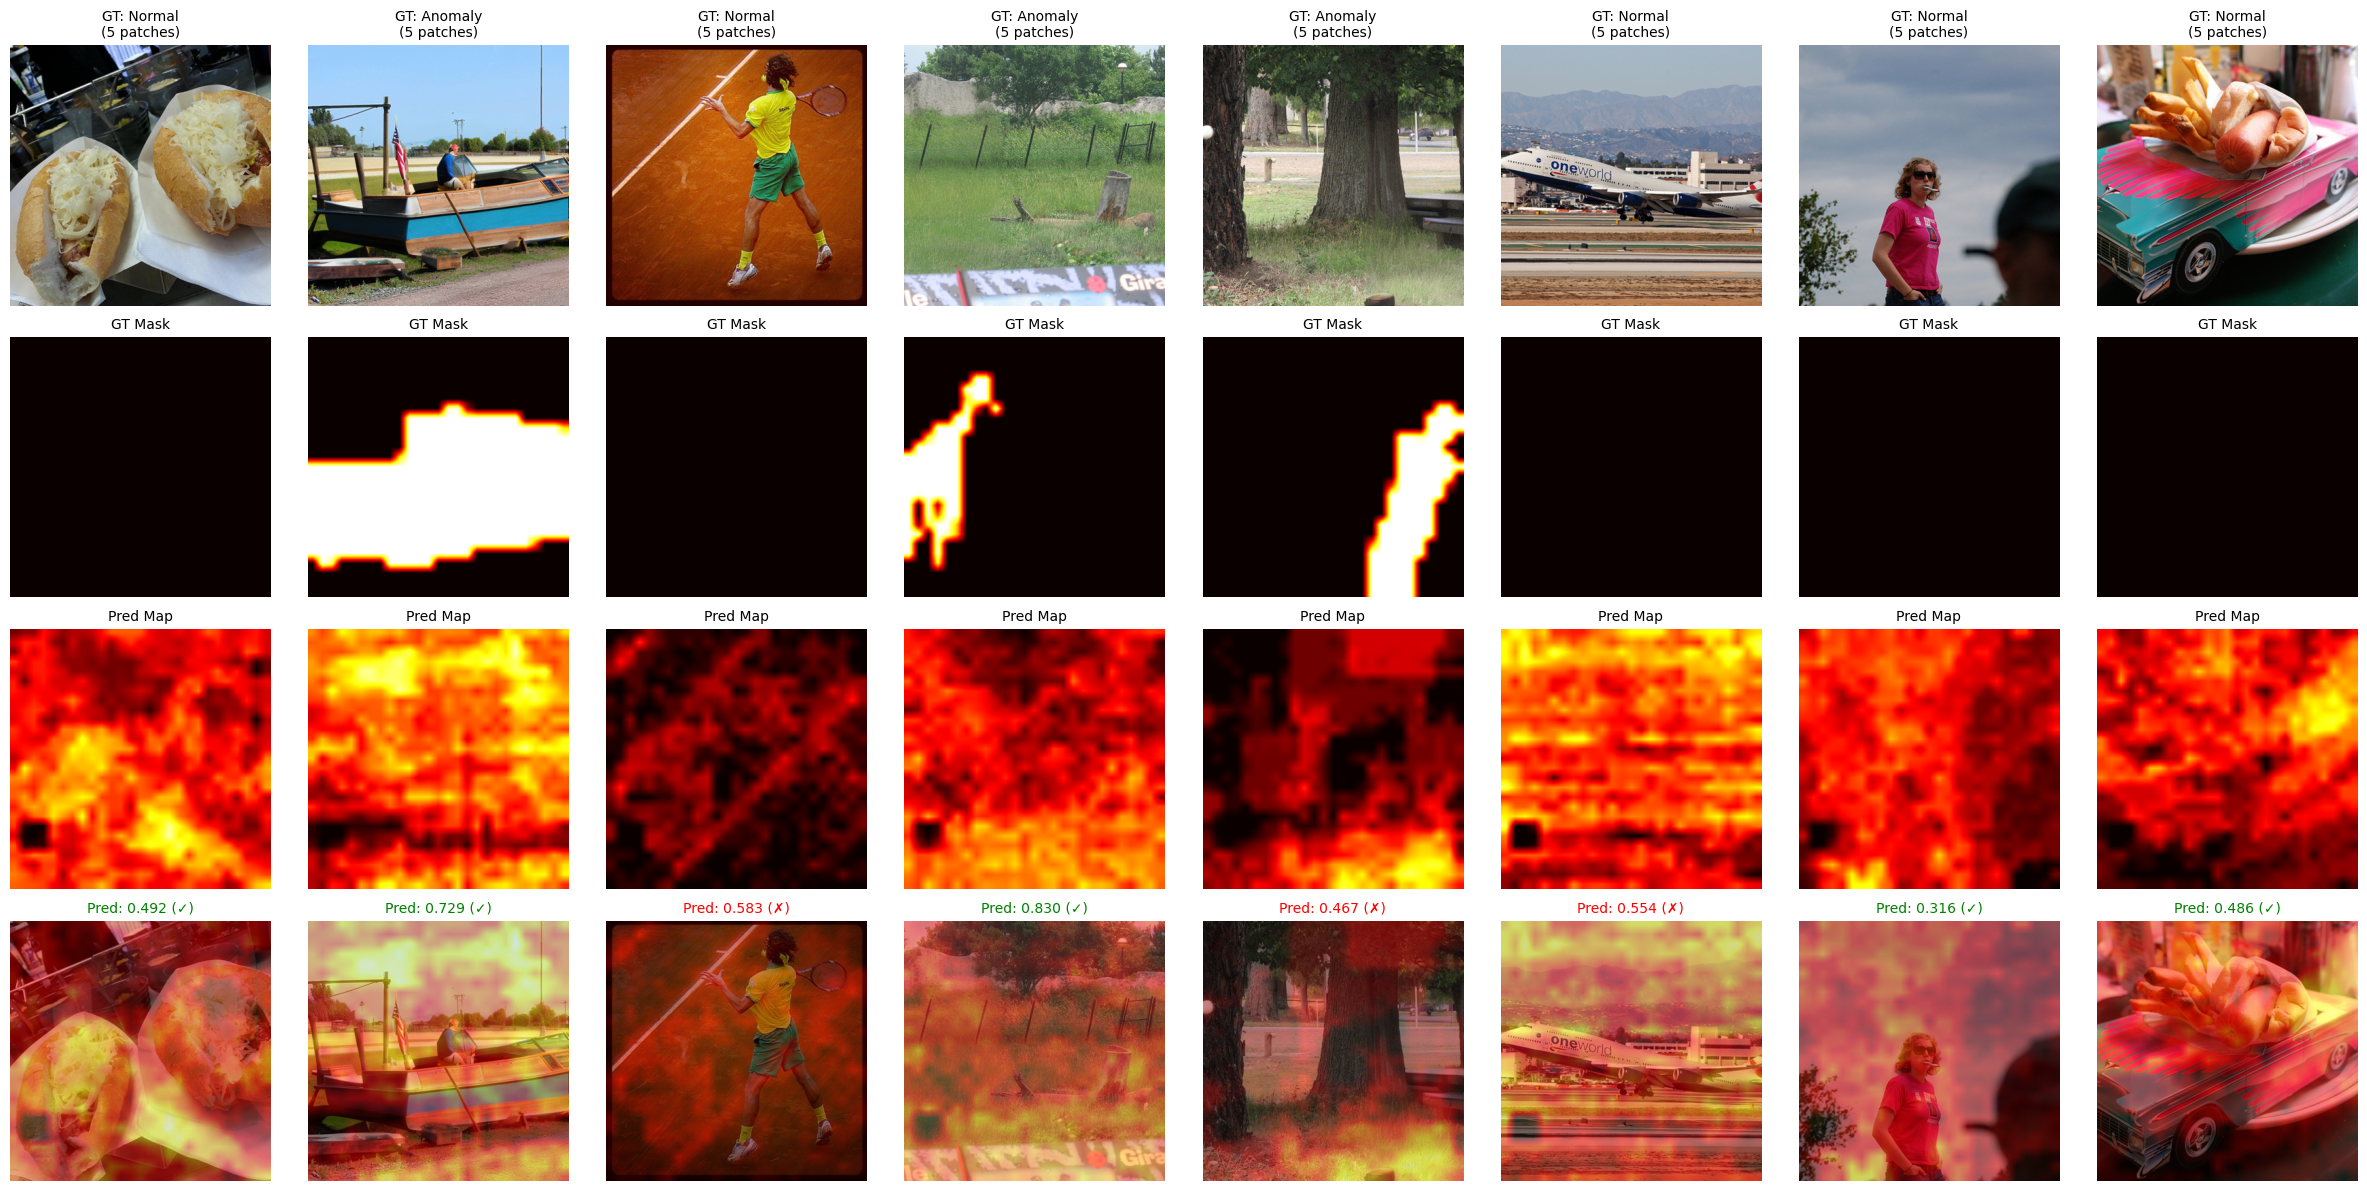

Visualization saved to: ./checkpoints/predictions_test.png


In [10]:


# Run visualization on test set
visualize_predictions(best_detector, test_dataset, num_samples=8, device=config.device, split_name="test")

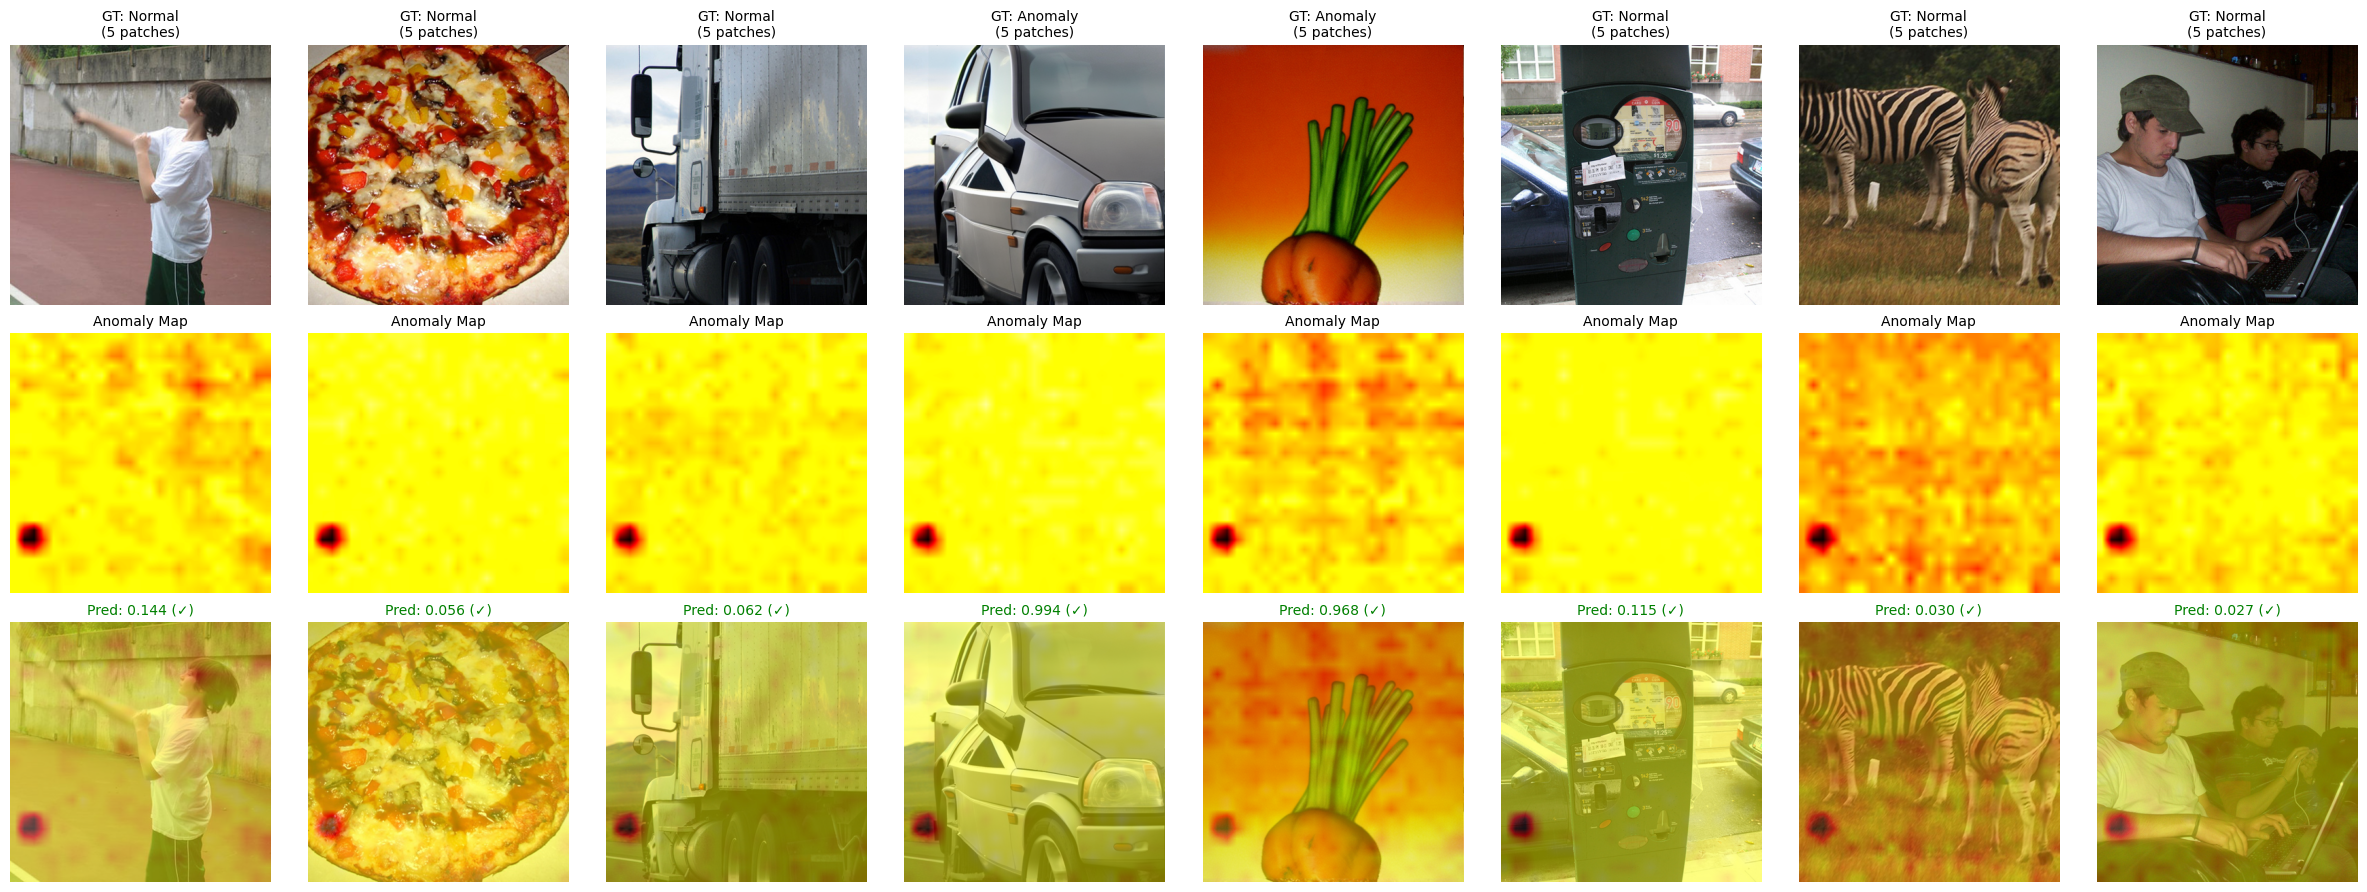

Visualization saved to: ./checkpoints/predictions_test.png


In [12]:
# Compute detailed metrics on test set with anyres
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

def compute_metrics(model, dataloader, device, split_name="test"):
    """Compute detailed metrics with anyres preprocessing"""
    model.eval()
    
    all_preds = []
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Computing metrics on {split_name}"):
            patches_list = [patches.to(device) for patches in batch["patches"]]
            labels = batch["label"].to(device)
            
            predictions = model.get_anomaly_fetures_from_images(
                patches_list,
                with_attention_map=False
            )
            
            all_probs.extend(predictions.cpu().numpy().flatten())
            all_preds.extend((predictions > 0.5).float().cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())
    
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    
    # Classification report
    print("\n" + "="*80)
    print(f"Classification Report ({split_name.upper()}):")
    print("="*80)
    print(classification_report(all_labels, all_preds, 
                                target_names=['Normal', 'Anomaly'],
                                digits=4))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print("="*80)
    print(f"                 Predicted Normal  Predicted Anomaly")
    print(f"Actual Normal    {cm[0,0]:>16d}  {cm[0,1]:>17d}")
    print(f"Actual Anomaly   {cm[1,0]:>16d}  {cm[1,1]:>17d}")
    
    # ROC AUC
    auc = roc_auc_score(all_labels, all_probs)
    print(f"\nROC AUC Score: {auc:.4f}")
    
    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {split_name.upper()} Set (AnyRes)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(config.checkpoint_dir, f'roc_curve_{split_name}.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nROC curve saved to: {config.checkpoint_dir}/roc_curve_{split_name}.png")
    
    return {
        'predictions': all_preds,
        'probabilities': all_probs,
        'labels': all_labels,
        'auc': auc,
        'confusion_matrix': cm
    }

# Compute metrics on test set
print("Evaluating on TEST set...")
test_metrics = compute_metrics(best_detector, test_loader, config.device, split_name="test")

In [13]:
# Export the final model
final_model_path = "./finetuned_anomaly_detector.pt"
best_detector.save_checkpoint(final_model_path)
print(f"Final model exported to: {final_model_path}")
print(f"File size: {os.path.getsize(final_model_path) / (1024**2):.2f} MB")

# Save training configuration
config_dict = {
    "vision_tower_name": config.vision_tower_name,
    "anomaly_expert_path": config.anomaly_expert_path,
    "batch_size": config.batch_size,
    "num_epochs": config.num_epochs,
    "learning_rate": config.learning_rate,
    "weight_decay": config.weight_decay,
    "image_size": config.image_size,
    "image_aspect_ratio": config.image_aspect_ratio,
    "num_grid_pinpoints": len(config.image_grid_pinpoints),
    "best_epoch": best_epoch,
    "best_eval_loss": float(best_eval_loss),
    "test_auc": float(test_metrics['auc']),
    "dataset_splits": {
        "train": len(train_dataset),
        "eval": len(eval_dataset),
        "test": len(test_dataset)
    }
}

config_path = os.path.join(config.checkpoint_dir, "training_config.json")
with open(config_path, 'w') as f:
    json.dump(config_dict, f, indent=4)

print(f"Training configuration saved to: {config_path}")

Evaluating on TEST set...


Computing metrics on test:   0%|          | 0/400 [00:45<?, ?it/s]



Evaluating on TEST set...


Computing metrics on test:   0%|          | 0/400 [00:45<?, ?it/s]



ValueError: too many values to unpack (expected 2)

In [ ]:
# # Export the final model
# final_model_path = "./finetuned_anomaly_detector.pt"
# best_detector.save_checkpoint(final_model_path)
# print(f"Final model exported to: {final_model_path}")
# print(f"File size: {os.path.getsize(final_model_path) / (1024**2):.2f} MB")

# # Save training configuration
# import json
# config_dict = {
#     "vision_tower_name": config.vision_tower_name,
#     "anomaly_expert_path": config.anomaly_expert_path,
#     "batch_size": config.batch_size,
#     "num_epochs": config.num_epochs,
#     "learning_rate": config.learning_rate,
#     "weight_decay": config.weight_decay,
#     "image_size": config.image_size,
#     "best_epoch": best_epoch,
#     "best_val_loss": float(best_val_loss),
#     "final_val_auc": float(metrics['auc'])
# }

# config_path = os.path.join(config.checkpoint_dir, "training_config.json")
# with open(config_path, 'w') as f:
#     json.dump(config_dict, f, indent=4)

# print(f"Training configuration saved to: {config_path}")

In [ ]:
# Inference example on a single image with anyres
def infer_single_image(model, image_path, image_processor, device='cpu'):
    """
    Run inference on a single image using anyres preprocessing.
    
    Args:
        model: The OVAnomalyDetector model
        image_path: Path to the image file
        image_processor: Image processor for preprocessing
        device: Device to run inference on
    
    Returns:
        Dictionary with prediction results and anomaly map
    """
    model.eval()
    
    # Load and preprocess image with anyres
    image = Image.open(image_path).convert("RGB")
    
    # Process with anyres strategy - returns [num_patches, 3, 384, 384]
    patches = process_anyres_image(image, image_processor, config.image_grid_pinpoints)
    patches = patches.to(device)
    num_patches = patches.shape[0]
    
    with torch.no_grad():
        # Get prediction and anomaly map
        patches_list = [patches]
        pred, _, anomaly_map = model.get_anomaly_fetures_from_images(
            patches_list,
            with_attention_map=True,
            anomaly_map_size=(384, 384)
        )
    
    pred_value = pred.item()
    pred_label = "Anomaly" if pred_value > 0.5 else "Normal"
    confidence = pred_value if pred_value > 0.5 else (1 - pred_value)
    
    # Get anomaly map - average across all patches
    anom_map = anomaly_map[:num_patches, 0].mean(dim=0).cpu().numpy()
    
    return {
        'prediction': pred_label,
        'confidence': confidence,
        'score': pred_value,
        'anomaly_map': anom_map,
        'num_patches': num_patches,
        'image': np.array(image)
    }

# Example usage
print("\nInference Example with AnyRes:")
print("="*80)
print("Usage:")
print("  result = infer_single_image(best_detector, 'path/to/image.png', image_processor, config.device)")
print("  print(f\"Prediction: {result['prediction']} (confidence: {result['confidence']:.2%})\")")
print("  print(f\"Number of patches: {result['num_patches']}\")")
print("\nThe model is ready for inference with anyres preprocessing!")

## Summary

This notebook provides a complete fine-tuning pipeline for the Anomaly OV model with **AnyRes preprocessing** and **proper train/eval/test splits**:

### Dataset Structure:
```
./finetune_dataset/
├── train/      (4,347 images)
│   ├── inpainted/
│   ├── masks/
│   └── COCO_real/
├── eval/       (931 images)
│   ├── inpainted/
│   ├── masks/
│   └── COCO_real/
└── test/       (933 images)
    ├── inpainted/
    ├── masks/
    └── COCO_real/
```

### Key Features:
1. **Model Architecture**: 
   - Vision Encoder: SigLip (frozen)
   - Anomaly Expert: AnomalyOV (trainable)
   
2. **Dataset with AnyRes**: 
   - Real images (no anomaly) - label 0
   - Inpainted images (with anomalies) - label 1
   - Binary masks for anomaly regions
   - **Multi-patch processing**: Images divided into patches based on aspect ratio
   - **Variable resolution**: Adapts to image dimensions using grid pinpoints

3. **Training**:
   - Binary Cross-Entropy loss
   - AdamW optimizer with weight decay
   - Cosine annealing learning rate schedule
   - Handles variable number of patches per image
   - Train on train set, monitor eval set, final evaluation on test set
   
4. **Evaluation**:
   - Classification metrics on test set (accuracy, precision, recall, F1)
   - ROC AUC score
   - Visual anomaly maps aggregated across patches
   - Separate metrics for train/eval/test splits
   
5. **Model Export**:
   - Save/load checkpoints using `detector.save_checkpoint()`
   - Load with `OVAnomalyDetector.load_from_checkpoint()`
   - Training config saved with dataset statistics

### AnyRes Strategy:
- Configuration loaded from `config.json`:
  - `image_aspect_ratio`: "anyres_max_9"
  - `image_grid_pinpoints`: 36 possible resolution configurations
- Each image is processed into multiple patches (1-10+ depending on size/aspect ratio)
- Model aggregates features across all patches for final prediction
- Better preserves fine-grained details and handles various aspect ratios

### Next Steps:
- Adjust hyperparameters (learning rate, batch size, epochs)
- Experiment with focal loss for class imbalance
- Fine-tune more layers (e.g., vision encoder)
- Apply data augmentation
- Test on different datasets with varying aspect ratios